In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebrals

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        break
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Initial Labels Inspection

In [9]:
training_labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

training_labels_df.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


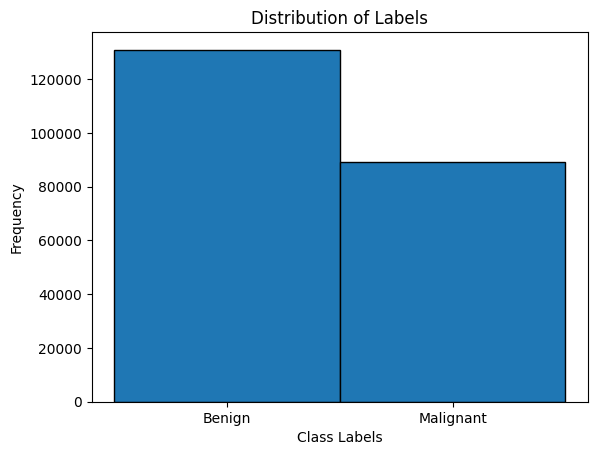

In [10]:
import matplotlib.pyplot as plt

plt.hist(training_labels_df['label'], bins=[-.5, .5, 1.5], edgecolor='black', align='mid')
plt.xticks([0, 1], ['Benign', 'Malignant']) 
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.show()

## Label Inspection Findings
    - The data is imbalanced as about 30% more benign samples are in training set than malignant samples.
    - This will need to be accounted for when training to avoid a bias towards negative(0) predictions

## Inspect Training Images
    - Figure out how labels map to images
    - Visualize an image

/kaggle/input/histopathologic-cancer-detection/train/8e294a0fe82d36c9ae921ef2cc76ed0d0691b90f.tif


IMAGE DIMENSIONS:
96 x 96 pixel image w/ 3 channels


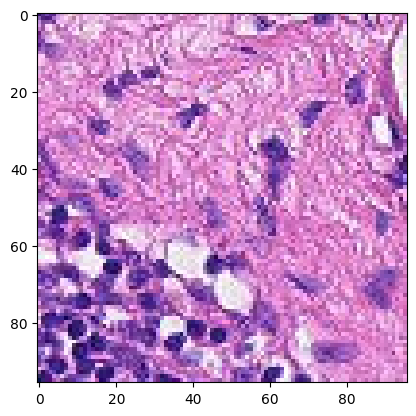

In [11]:
from PIL import Image
import os

training_root = "/kaggle/input/histopathologic-cancer-detection/train"

#get random label id - this likely links to an image file
image_id = training_labels_df.iloc[25, 0]

image_path = os.path.join(training_root, f"{image_id}.tif")
print(image_path)

image = Image.open(image_path)

height, width = image.size
channels = len(image.getbands())

print(f"\n\nIMAGE DIMENSIONS:\n{height} x {width} pixel image w/ {channels} channels")

plt.imshow(image)
plt.show()

## Handling ~ 6GB of Image Data
    - Pytorch has libraries to handle loading these memory intensive files.
    - I have implemented a subclass of Pytorch's Dataset to handling getting an image and its label
    - I use Pytorch's DataLoader to batch dataset and optimize performance with:
        - num_workers: # of cpu processes
        - pini_memory: Retain image data in memory pages so they do not get swapped out
        - persistent_workers: retain work processes to avoid reboot time between epochs
        - prefetch_factor: prefatch batches will doing forward pass on the current batch
    - Handle label imbalance by sampling 80,000 positive and negative samples to train and validate against

In [56]:
from PIL import Image
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
from torchvision import utils
import torch.optim as optim

In [13]:
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx, 0]
        img_name = os.path.join(self.img_dir, f"{image_id}.tif")
        image = Image.open(img_name).convert("RGB")
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [14]:
tr_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToTensor()
])

In [15]:
positive_samples = training_labels_df[training_labels_df['label'] == 1]
negative_samples = training_labels_df[training_labels_df['label'] == 0]

# Sample 80,000 positive and 80,000 negative samples
positive_samples = positive_samples.sample(n=80000, random_state=11)
negative_samples = negative_samples.sample(n=80000, random_state=11)

combined_samples = pd.concat([positive_samples, negative_samples])

# Shuffle the combined samples
combined_samples = combined_samples.sample(frac=1, random_state=11).reset_index(drop=True)

In [16]:
train_size = int(0.8 * len(combined_samples))
train_df = combined_samples[:train_size]
val_df = combined_samples[train_size:]

In [26]:
train_dataset = ImageDataset(df=train_df, img_dir=training_root, transform=tr_transform)
val_dataset = ImageDataset(df=val_df, img_dir=training_root, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

## CNN Architecture
    - 4 convolutions, all with a relu activation, then a batch norm, and a max pooling layer
    - 2 fully connected layers, with the final layer being a single neuron that has a sigmoid activation
    
    - The relu's will emphasis the features drwan from the convolution with high magnitude
    - The batch norm will improve convergence speed and produce a more general model for inference
    - The max pooling will decrease the image data size
    - The FC layers will be provide input the the sigmoid function for output

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.flatten_sz = 256 * 6 * 6
        self.fc1 = nn.Linear(self.flatten_sz, 50)
        self.fc2 = nn.Linear(50, 1)  

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        
        x = x.view(-1, self.flatten_sz)  
        
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        
        return x


In [28]:
cnn_model = CNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

cnn_model.to(device)

Using device: cuda


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [20]:
!pip install torchsummary

In [29]:
from torchsummary import summary

summary(cnn_model, input_size=(3, 96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
       BatchNorm2d-2           [-1, 32, 96, 96]              64
         MaxPool2d-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          18,496
       BatchNorm2d-5           [-1, 64, 48, 48]             128
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
       BatchNorm2d-8          [-1, 128, 24, 24]             256
         MaxPool2d-9          [-1, 128, 12, 12]               0
           Conv2d-10          [-1, 256, 12, 12]         295,168
      BatchNorm2d-11          [-1, 256, 12, 12]             512
        MaxPool2d-12            [-1, 256, 6, 6]               0
           Linear-13                   [-1, 50]         460,850
           Linear-14                   

## Training Function
    - Each epoch will conclude in accuracy score against validation set to determine whether to early stop.
    - Early stopping set with parameters, patience and delta
    - TQDM used to track train loss, validation loss, and validation accuracy
    - Adam used for optimization algorithm, which has been shown to proved one of the fastest convergence times in general
    - Binary Cross Entropy Loss used since this is a binary classification problem
    - NOTE: .5 is set as the threshold when doing inference on this model

In [30]:
epochs = 10
learning_rate = .0005
criterion = nn.BCELoss()

optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [31]:
from tqdm import tqdm

In [32]:
delta = .0075
patience = 4
best_val_acc = 0

In [33]:
for epoch in range(epochs):
    cnn_model.train()
    
    running_loss = 0.0
    
    train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = cnn_model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loader.set_postfix(loss=running_loss/len(train_loader))
    
    cnn_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    if (val_acc - best_val_acc) <= delta and (patience ):
        break
    elif val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn_model.state_dict(), '/kaggle/working/cnn_model.pth')


Epoch 1/10, Training Loss: 0.3530, Validation Loss: 0.2860, Validation Accuracy: 0.8859


Epoch 2/10, Training Loss: 0.2582, Validation Loss: 0.2288, Validation Accuracy: 0.9113


Epoch 3/10, Training Loss: 0.2220, Validation Loss: 0.2747, Validation Accuracy: 0.8938


## Submission
    - Read in test dataframe, setup dataset, setup dataloader, and then iterate over batches
    - set model into eval model so no gradients are calculated

In [39]:
test_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
test_df.head(5)

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [45]:
test_dataset = ImageDataset(df=test_df, img_dir="/kaggle/input/histopathologic-cancer-detection/test", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [50]:
cnn_model.eval()
predictions = []

for images, labels in test_loader:
    images = images.to(device)
    outputs = cnn_model(images)
            
    predicted = (outputs > 0.5).float().reshape(-1)
    predictions.extend(predicted.cpu().numpy())

In [55]:
test_df['label'] = predictions
test_df.to_csv('submission.csv', index=False)